# PR9-1 Clusteringmodellen

## Opdracht

# Implementatie

## Library Imports

In [49]:
import pandas as pd
import random
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from sklearn import metrics
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import numpy as np
import sqlite3
import csv
import pyodbc

## Data inlezen en samenvoegen

In [50]:
sales_con = None
crm_con = None
staff_con = None
GO_SALES_PRODUCT_FORECASTData = None
GO_SALES_INVENTORY_LEVELSData = None



try : 
        sales_con = sqlite3.connect("../Assets/Week 2/go_sales.sqlite")
        print("Connected to go_sales sqlite.")


        crm_con = sqlite3.connect("../Assets/Week 2/go_crm.sqlite")
        print("Connected to go_crm sqlite.")


        staff_con = sqlite3.connect("../Assets/Week 2/go_staff.sqlite")
        print("Connected to go_staff sqlite.")

        GO_SALES_PRODUCT_FORECASTData = pd.read_csv("../Assets/Week 2/GO_SALES_PRODUCT_FORECASTData.csv")
        print("Connected to GO_SALES_PRODUCT_FORECASTData")

        GO_SALES_INVENTORY_LEVELSData = pd.read_csv("../Assets/Week 2/GO_SALES_INVENTORY_LEVELSData.csv", header=0, index_col=False)
        print("Connected to GO_SALES_INVENTORY_LEVELSData.csv")


except sqlite3.Error as error: 
        print("Failed to read data from sqlite table", error)

DataWarehouse_con = None

try : 
        pass
except : 
        pass




Connected to go_sales sqlite.
Connected to go_crm sqlite.
Connected to go_staff sqlite.
Connected to GO_SALES_PRODUCT_FORECASTData
Connected to GO_SALES_INVENTORY_LEVELSData.csv


In [51]:
global sales_branch
sales_branch = pd.read_sql_query("SELECT * FROM {}".format("sales_branch"),sales_con)
sales_branch = sales_branch[sales_branch.columns.drop(list(sales_branch.filter(regex="TRIAL")))]

global retailer_site
retailer_site = pd.read_sql_query("SELECT * FROM {}".format("retailer_site"),sales_con)
retailer_site = retailer_site[retailer_site.columns.drop(list(retailer_site.filter(regex="TRIAL")))]

global country
country = pd.read_sql_query("SELECT * FROM {}".format("country"),sales_con)
country = country[country.columns.drop(list(country.filter(regex="TRIAL")))]

global product
product = pd.read_sql_query("SELECT * FROM {}".format("product"),sales_con)
product = product[product.columns.drop(list(product.filter(regex="TRIAL")))]

global product_type
product_type = pd.read_sql_query("SELECT * FROM {}".format("product_type"),sales_con)
product_type = product_type[product_type.columns.drop(list(product_type.filter(regex="TRIAL")))]

global product_line
product_line = pd.read_sql_query("SELECT * FROM {}".format("product_line"),sales_con)
product_line = product_line[product_line.columns.drop(list(product_line.filter(regex="TRIAL")))]

global order_header
order_header = pd.read_sql_query("SELECT * FROM {}".format("order_header"),sales_con)
order_header = order_header[order_header.columns.drop(list(order_header.filter(regex="TRIAL")))]

global order_details
order_details = pd.read_sql_query("SELECT * FROM {}".format("order_details"),sales_con)
order_details = order_details[order_details.columns.drop(list(order_details.filter(regex="TRIAL")))]


In [52]:
# dataset = pd.merge(sales_branch, country, left_on="COUNTRY_CODE", how="inner", right_on="COUNTRY_CODE")
# orders = pd.merge(order_header, order_details, left_on="ORDER_NUMBER", how="inner", right_on="ORDER_NUMBER")
# dataset = pd.merge(orders, dataset, left_on="SALES_BRANCH_CODE", how="inner", right_on="SALES_BRANCH_CODE")
# dataset = pd.merge(dataset, product, left_on="PRODUCT_NUMBER", how="inner", right_on="PRODUCT_NUMBER")
# dataset = pd.merge(dataset, product_type, left_on="PRODUCT_TYPE_CODE", how="inner", right_on="PRODUCT_TYPE_CODE")
# dataset = pd.merge(dataset, product_line, left_on="PRODUCT_LINE_CODE", how="inner", right_on="PRODUCT_LINE_CODE")


# dataset = dataset.loc[:,
#                       [
#                           "SALES_BRANCH_CODE", 
#                           "COUNTRY_CODE",
#                         #   "PRODUCT_TYPE_CODE",
#                           "PRODUCT_LINE_CODE",
#                           "UNIT_COST", 
#                           "UNIT_PRICE",
#                           "UNIT_SALE_PRICE",
#                           "PRODUCTION_COST"
#                       ]
#                      ]

#aantal gekozen rijen verminderen voor minder drukte in visuals
# dataset = dataset.iloc[:3063]

dataset = sales_branch.loc[:,["SALES_BRANCH_CODE","COUNTRY_CODE"]]


print(dataset.columns)
display(dataset)

Index(['SALES_BRANCH_CODE', 'COUNTRY_CODE'], dtype='object')


,SALES_BRANCH_CODE,COUNTRY_CODE
0,13,2
1,14,2
2,15,10
3,17,4
4,18,4
5,19,3
6,20,3
7,21,3
8,22,3
9,23,1


## One-hot encoding

In [53]:
# dummies_dataframe = pd.get_dummies(dataset.loc[:,
#                                                [
#                                                    "COUNTRY_CODE",
#                                                 #    "PRODUCT_TYPE_CODE",
#                                                    "PRODUCT_LINE_CODE"
#                                                    ]
#                                                    ])



# dummies_dataframe.columns


# dataset = pd.concat([dataset, dummies_dataframe], axis=1)

# dataset = dataset.drop([
#     "COUNTRY_CODE",
#     # "PRODUCT_TYPE_CODE",
#     "PRODUCT_LINE_CODE"], axis=1)

# dataset.columns

## Cluster model bouwen

In [54]:
cluster_amount = 7

kmeans = KMeans(n_clusters=cluster_amount, random_state=42) 
prediction_results = kmeans.fit_predict(dataset)

prediction_results



array([1, 2, 5, 2, 2, 2, 2, 2, 2, 2, 0, 6, 6, 6, 0, 0, 0, 6, 3, 4, 3, 3,
       3, 4, 3, 1, 1, 1])

In [55]:
kmeans_centra = pd.DataFrame(kmeans.cluster_centers_)

# kmeans_centra = kmeans_centra.rename(columns = {
#                     0 : "SALES_BRANCH_CODE",
#                     1 : "COUNTRY_CODE",
#                     2 : "PRODUCT_TYPE_CODE",
#                     3 : "PRODUCT_LINE_CODE",
#                     4 : "UNIT_COST",
#                     5 : "UNIT_PRICE",
#                     6 : "UNIT_SALE_PRICE",
#                     7 : "PRODUCTION_COST"
#  }
# )

kmeans_centra

,0,1
0,28.50,20.500
1,8.75,4.000
2,19.25,2.875
3,36.00,8.600
4,36.00,15.500
5,15.00,10.000
6,27.75,12.750


In [56]:
dataset["Centrum"] = prediction_results

display(dataset)

,SALES_BRANCH_CODE,COUNTRY_CODE,Centrum
0,13,2,1
1,14,2,2
2,15,10,5
3,17,4,2
4,18,4,2
5,19,3,2
6,20,3,2
7,21,3,2
8,22,3,2
9,23,1,2


In [57]:
dataset.groupby('Centrum', as_index = False)['Centrum'].count()

,Centrum
0,4
1,4
2,8
3,5
4,2
5,1
6,4


## Visuals

In [58]:
# plt.scatter(dataset['UNIT_SALE_PRICE'], dataset['Centrum'], color = 'k')
# plt.show()

In [59]:
pca = PCA(2)
pca_res = pca.fit_transform(dataset)
dataset["Cluster"] = kmeans.labels_
dataset["X"] = pca_res[:,0]
dataset["Y"] = pca_res[:,1]


display(dataset)

,SALES_BRANCH_CODE,COUNTRY_CODE,Centrum,Cluster,X,Y
0,13,2,1,1,13.386431,1.208791
1,14,2,2,2,12.442160,1.749697
2,15,10,5,5,7.808755,-4.643958
3,17,4,2,2,8.868480,1.292575
4,18,4,2,2,7.976043,1.734567
5,19,3,2,2,7.531788,3.068107
6,20,3,2,2,6.639350,3.510099
7,21,3,2,2,5.746913,3.952091
8,22,3,2,2,4.854475,4.394082
9,23,1,2,2,4.858404,6.619172


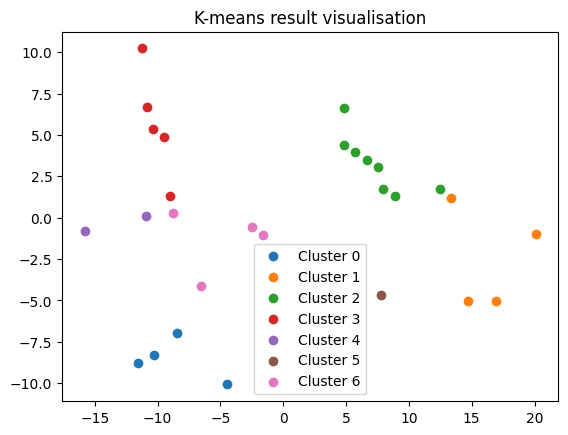

In [60]:

for i in range(cluster_amount) : 
    cluster = dataset[dataset["Cluster"] == i]
    plt.scatter(cluster["X"], cluster["Y"], label=f"Cluster {i}" )

plt.legend()
plt.title("K-means result visualisation")
plt.xlabel="X"
plt.ylabel="Y"

plt.show()
